## Здравствуйте, меня зовут *Михаил Солоткий*, вот моё Задание №2 по курсу ПСАД-2019!

In [115]:
import pandas as pd
import numpy as np
import scipy as sp
from collections import defaultdict
from matplotlib import pyplot as plt
from scipy.stats import t, norm, beta

import seaborn as sns
sns.set()

np.random.seed(228)

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

### Задача 1  

Задана выборка, включающая значения переменной $X$. 

X sample mean:  5.206


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


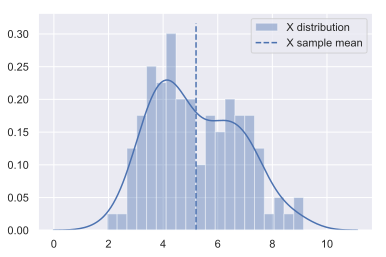

In [3]:
X = pd.read_excel('t1_data.xlsx').values.ravel()

sns.distplot(X, label='X distribution', bins=20)
plt.vlines(X.mean(), *plt.ylim(), linestyles='--', colors='b', label="X sample mean")
plt.legend()
print("X sample mean: ", np.round(X.mean(), 3))
plt.show()

Определите доверительный интервал для математического ожидания на уровне $\alpha$ (для каждого $\alpha$ из списка) c использованием...

In [4]:
alpha_list = np.array([0.1, 0.075, 0.05, 0.025, 0.01]) 

Распределения Стьюдента

In [62]:
def student_mci(data, alpha=0.05):
    n = data.size
    m = data.mean()
    centered_data = data - m
    non_biased_variance = (centered_data ** 2).sum() / (n - 1)
    s = np.sqrt(non_biased_variance)
    centered_data * np.sqrt(n) / non_biased_variance
    left = m - t.ppf(1 - alpha / 2, n - 1) * s / np.sqrt(n)
    right = m + t.ppf(1 - alpha / 2, n - 1) * s / np.sqrt(n)
    return left, right

Бутстрэп оценивания

In [129]:
def bootstrap_mci(data, alpha=0.05):
    n = data.size
    pseudo_samples_mean = []
    num_of_pseudo_samplings = 113419
    for i in range(num_of_pseudo_samplings):
        ind = np.random.randint(low=0, high=n, size=n)
        pseudo_samples = data[ind]
        pseudo_samples_mean.append(pseudo_samples.mean())
    pseudo_samples_mean = np.array(pseudo_samples_mean)
    pseudo_samples_mean = np.sort(pseudo_samples_mean)
    ind_left = 0
    ind_right = num_of_pseudo_samplings - 1
    num_to_drop = int(num_of_pseudo_samplings * alpha)
    for i in range(num_to_drop):
        left_diff = pseudo_samples_mean[ind_left + 1] - pseudo_samples_mean[ind_left]
        right_diff = pseudo_samples_mean[ind_right] - pseudo_samples_mean[ind_right - 1]
        if left_diff > right_diff:
            ind_left += 1
        else:
            ind_right -= 1
    return pseudo_samples_mean[ind_left], pseudo_samples_mean[ind_right]

Сравните результаты и сделайте выводы.

In [130]:
res = defaultdict(list)
res["alpha"] = alpha_list
res["Student"] = [np.round(student_mci(X, alpha), 3) for alpha in alpha_list]
res["Bootstrap"] = [np.round(bootstrap_mci(X, alpha), 3) for alpha in alpha_list]
res = pd.DataFrame(res)
res

,alpha,Student,Bootstrap
0,0.100,"[4.956, 5.456]","[4.721, 5.399]"
1,0.075,"[4.935, 5.477]","[4.755, 5.423]"
2,0.050,"[4.907, 5.505]","[4.8, 5.46]"
3,0.025,"[4.863, 5.549]","[4.753, 5.504]"
4,0.010,"[4.81, 5.602]","[4.757, 5.565]"


**Выводы:** t-тест Стьюдента корректно использовать только для нормальных iid выборок, используют и не только для них. Доверительный интервал для распределения Стьюдента симметричный, что вытекает из симметричности нормального распределения, но для наших данных это не совсем так. При использовании bootstrap удалось получить более точные хорошие правые границы интервалов как раз за счёт отказа от симметричности, но у t-теста величина интервалов оказалась меньше. Вообще, непонятно, плюс это или минус, ибо оба метода математически некорректны: t-тест, потому что ЦПТ не выполняется на конечных выборках, а величина погрешности приближения ЦПТ в нём никак не учитывается, bootstrap в принципе ограничен выборкой, которая может оказаться нерепрезентативной, и величина интервала не обязана сходиться к нулю при количестве сгенерированных псевдовыборок стремящемся к бесконечности. Тем не менее (что интересно), bootstrap даёт более узкий доверительный интервал, чем t-тест. Мб это связано с тем, что t-тест в принципе консервативен, так как у распределения Стьюдента (любого) хвосты тяжелее, чем у стандартного нормального. Как раз за счёт консервативности t-тест более-менее оправдано использовать на ненормальных выборках (типа всё-равно у нас широкий доверительный интервал, мы как бы почти ничего не утверждаем и почти никогда не врём).

### Задача 2


Задана выборка $Y$ результатов распознавания для некоторой задачи классификации.

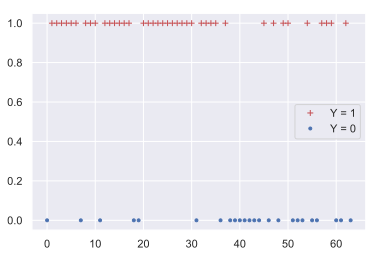

In [100]:
Y = pd.read_excel("t2_data.xlsx").values.ravel()

plt.plot(np.arange(Y.size)[Y == 1], np.count_nonzero(Y == 1) * [1], 'r+', label='Y = 1')
plt.plot(np.arange(Y.size)[Y == 0], np.count_nonzero(Y == 0) * [0], 'b.', label='Y = 0')
plt.legend()
plt.show()

Оцените доверительный интервал для показателя *ACCURACY* с использованием...

Метода Клоппера-Пирсона (с использованием аппроксимации через бета-распределение)

In [120]:
def bin_clopper_pearson(data, alpha=0.05):
    n = data.size
    estimate = np.count_nonzero(data)
    left_bound = beta.ppf(alpha / 2, estimate, n - estimate + 1)
    right_bound = beta.ppf(1 - alpha / 2, estimate + 1, n - estimate)
    return left_bound, right_bound

Нормальной аппроксимации

In [123]:
def bin_normal_approx(data, alpha=0.05):
    n = data.size
    estimate = data.mean()
    right_quantile = norm.ppf(1 - alpha / 2)
    std_deviation = np.sqrt(estimate * (1 - estimate) / n)
    left_bound = estimate - right_quantile * std_deviation
    right_bound = estimate + right_quantile * std_deviation
    return left_bound, right_bound

Сравните результаты и сделайте выводы.

In [124]:
res = defaultdict(list)
res["alpha"] = alpha_list
res["Clopper-Pearson"] = [np.round(bin_clopper_pearson(Y, alpha), 3) for alpha in alpha_list]
res["Normal"] = [np.round(bin_normal_approx(Y, alpha), 3) for alpha in alpha_list]
res = pd.DataFrame(res)
res

,alpha,Clopper-Pearson,Normal
0,0.100,"[0.515, 0.726]","[0.525, 0.725]"
1,0.075,"[0.506, 0.733]","[0.517, 0.733]"
2,0.050,"[0.495, 0.743]","[0.506, 0.744]"
3,0.025,"[0.478, 0.757]","[0.489, 0.761]"
4,0.010,"[0.457, 0.774]","[0.469, 0.781]"


**Выводы:** Аппроксимация с помощью бета-распределения более консервативная. То, что у нормальной аппроксимации доверительные интервалы получаются более узкими значит (если предположить, что приближение с помощью бета-распределения достаточно точное), что аппроксимация с помощью нормального распределения довольно неточная на малых данных (что в принципе итак было понятно).

### Задача 3

Два предприятия выпускают  изделия одного и того же назначения. Предприятие I выпускает изделия с математическим ожиданием срока службы $T_1$, предприятие II выпускает изделия с математическим ожиданием срока службы $T_2$. Сроки службы изделий обоих предприятий распределены нормально и стандартные отклонения для них равны $\sigma_1$ и $\sigma_2$ соответственно. При этом $T_1 < T_2$, но изделия второго предприятия дороже.

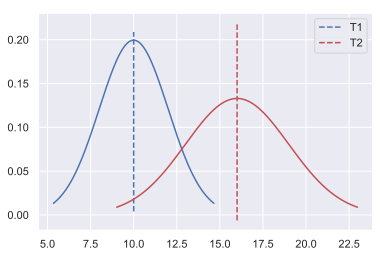

In [144]:
T1, T2, sigma1, sigma2 = 10, 16, 2, 3

def plot_T(T, sigma, c, label):
    norm = sp.stats.norm(loc=T, scale=sigma)
    x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 1000)
    plt.plot(x, norm.pdf(x), c=c)
    plt.vlines(T, *plt.ylim(), linestyles='--', colors=c, label=label)
    
plot_T(T1, sigma1, 'b', 'T1')
plot_T(T2, sigma2, 'r', 'T2')
plt.legend()
plt.show()

Третье предприятие утверждает, что ему удалось разработать технологию производства изделий со средним сроком службы  предприятия II, но по цене предприятия I. В качестве доказательства предлагаются результаты тестирования для $k$ изделий. 

Нулевая гипотеза $H_0$ предполагает, что на самом деле срок службы изделий предприятия III имеет распределение, совпадающее с распределением срока службы изделий предприятия I. Альтернативная гипотеза $H_1$ предполагает, что срок службы изделий предприятия III имеет распределение, совпадающее с распределением срока службы изделий предприятия II. Проверка этих двух предположений производится путем сравнения эмпирически оцененного среднего срока службы протестированных изделий предприятия III с некоторым порогом $T$. Конкретное значение $T$ находится из условия того, что допустимая ошибка первого рода равна $\alpha$.

In [145]:
def sample_from_T3(k):
    "Draws k samples from the 3rd company products lifetime distribution."
    T3, sigma3 = 14, 2.5  # Ooops, spoiler...
    return T3 + sigma3 * np.random.randn(k)

alpha = 0.05

Постройте график мощности такого теста в зависимости от $k$ и сделайте выводы.

In [146]:
def calc_type_2_error(n):
    initial_right_quantile = norm.ppf(1 - alpha / 2)
    right_bound_prob = norm.cdf(initial_right_quantile * sigma1 / sigma2 + (T2 - T1) * np.sqrt(n) / sigma2)
    left_bound_prob = norm.cdf(-initial_right_quantile * sigma1 / sigma2 + (T2 - T1) * np.sqrt(n) / sigma2)
    return right_bound_prob - left_bound_prob

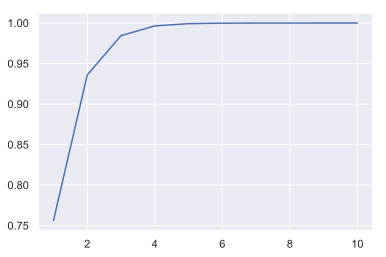

In [147]:
kmax = 10
type_2_error = []
krange = np.arange(1, kmax + 1)
for k in krange:
    type_2_error.append(1 - calc_type_2_error(k))
plt.plot(krange, type_2_error)

**Выводы:** С помощью среднего можно даже при малом объёме данных хорошо угадывать принадлежность к 1 из 2 распределений (внезапно быстро мощность сходится к 1). На практике нам неизвестна дисперсия (здесь же она указана), и если её нет, формально надо использовать t-критерий Стьюдента.